In [1]:
#imports

import numpy as np
import pandas as pd
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Angle
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, SkyRectangularAperture, aperture_photometry
from stdatamodels.jwst.datamodels import MirMrsApcorrModel
import stpsf
import poppy
from scipy.interpolate import interp1d
#from jwst.residual_fringe.utils import fit_residual_fringes_1d as rf1d
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.optimize import curve_fit
from regions import CircleSkyRegion, CirclePixelRegion, PixCoord
from spectral_cube import SpectralCube


plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

import warnings
import astropy.wcs as wcs
warnings.simplefilter('ignore', category=wcs.FITSFixedWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)
from spectral_cube.utils import PossiblySlowWarning
warnings.filterwarnings("ignore", category=PossiblySlowWarning)



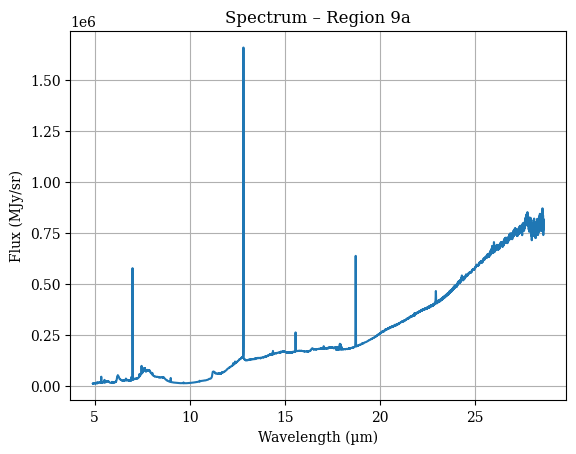

Index(['Region', 'Wavelength (µm)', 'Flux (mJy)', 'Error (mJy)', 'SB (MJy/sr)',
       'Error SB (MJy/sr)', 'Aperture (arcsec)', 'Apcorr', 'Aperture_ID'],
      dtype='object')


In [2]:
#This loads MJy/Sr data that was extracted with conical apperture with apperture correction
#but not background subtration and no flux stabilization

import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.nddata import StdDevUncertainty

# === Load CSV and filter only Region 14 ===
df = pd.read_csv("NGC253_MIRI_MRS_spectrum.csv")
df = df[df["Region"] == "9a"]  # Use exact match for Region 9a
# === Only include wavelengths >= 5.24 µm ===
#df = df[df["Wavelength (µm)"] >= 5.24]
df = df.sort_values("Wavelength (µm)")


# === Extract SB columns ===
wave     = df["Wavelength (µm)"].values * u.um
flux     = df["SB (MJy/sr)"].values * u.MJy / u.sr
err_all  = df["Error SB (MJy/sr)"].values * u.MJy / u.sr


# === Wrap errors as uncertainty ===
uncertainty = StdDevUncertainty(err_all)

# === Plot spectrum ===
plt.plot(wave, flux)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Flux (MJy/sr)")
plt.title("Spectrum – Region 9a")
plt.grid(True)
plt.show()

print(df.columns)



In [ ]:
from specutils import Spectrum1D
from collections import OrderedDict
import numpy as np

from pahfit.model import Model
model = Model.from_yaml('classic_miri.yaml')


#Spectrum part

spec = Spectrum1D(spectral_axis=wave, flux=flux, uncertainty=uncertainty)

# --- Mask NaNs and wavelength range ---
mask_wave = (spec.spectral_axis > 4.9 * u.um) & (spec.spectral_axis < 28.1 * u.um)
mask_valid = (~np.isnan(spec.flux)) & (~np.isnan(spec.uncertainty.array))
mask       = mask_wave & mask_valid

# --- Subset and scale ---
sub_spec = Spectrum1D(
    spectral_axis = spec.spectral_axis[mask],
    flux          = spec.flux[mask],
    uncertainty   = spec.uncertainty[mask]
)

spec = sub_spec

# --- Set metadata ---
if spec.meta is None:
    spec.meta = OrderedDict()

#spec.meta['instrument'] = 'spitzer.irs.*.[28]'

spec.meta['instrument'] = 'jwst.miri.mrs.*'


spec.set_redshift_to(0.000811)

# --- Run PAHFIT ---
model.guess(spec)
model.fit(spec)
model.save('my_output_9a.ecsv', overwrite=True)


In [ ]:
# This is the default plot that we can obtain!
# Make the plot
fig = model.plot(spec)

# Show the plot
plt.show()


In [ ]:
#I am trying to make the plot costum as JWST has so much of resolution and the default plot
# is based on spitzer which makes overcrowded and we cant see it properly. Improvement is so welcomed here
import warnings
from astropy.utils.exceptions import AstropyDeprecationWarning
import matplotlib.pyplot as plt
import numpy as np

# Suppress the Spectrum1D deprecation warning
warnings.filterwarnings(
    "ignore",
    category=AstropyDeprecationWarning,
    message="The Spectrum1D class is deprecated"
)

# 1) Draw the default PAHFIT figure
fig = model.plot(spec)
ax = fig.axes[0]   # main spectrum panel

# 2) Modify the observed spectrum line
for line in ax.get_lines():
    if line.get_marker() == 'o':        # observed spectrum markers
        line.set_marker('')             # remove markers
        line.set_linestyle('-')        # dashed line
        line.set_linewidth(1.2)         # consistent width
        line.set_color('g')             # green
        #line.set_dashes([6, 6])         # custom dash: 6pt dash, 6pt gap

        # Optional: safely set y-limits for log scale
        y = line.get_ydata()
        y_positive = y[np.isfinite(y) & (y > 0)]
        if len(y_positive) > 0:
            ax.set_yscale('log')
            ax.set_ylim(np.min(y_positive) * 0.8, np.max(y_positive) * 1.2)

# 3) Redraw and show
fig.canvas.draw()
plt.tight_layout()
plt.savefig('pahfit_9.png')
plt.show()
